In [1]:
# Import
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('A rmg company data.csv', index_col='Week', thousands=',')

In [3]:
data.head()

,Production
Week,
09-01-15 1:00,79829
16-01-15 1:00,78000
23-01-15 1:00,73639
30-01-15 1:00,84139
06-02-15 1:00,82777


In [4]:
# Make the index as a time series
data.index = pd.to_datetime(data.index)


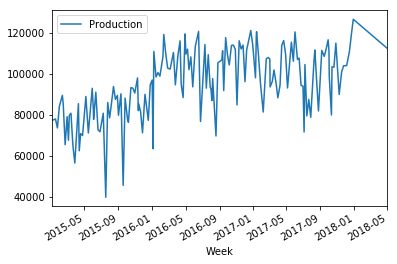

In [5]:
# Plot the time series
data.plot()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2015-09-01 01:00:00 to 2018-05-01 01:00:00
Data columns (total 1 columns):
Production    157 non-null int64
dtypes: int64(1)
memory usage: 2.5 KB


In [7]:
# Test , train data
train_set = data.head(149)
test_set = data.tail(8)
tf.cast(train_set,tf.float32)
tf.cast(test_set,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(8, 1) dtype=float32>

In [8]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [10]:
# Batch Function
def next_batch(training_data,batch_size,steps):
    
    
    # Grabing a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Creating Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [11]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 8
# 100 neuron layer
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
learning_rate = 0.001 
# how many iterations to go through (training steps)
num_train_iterations = 600
# Size of the batch of data
batch_size = 1

In [12]:
# Placeholder
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [13]:
# Cell in RNN
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 


In [14]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [15]:
# Loss function and optimizer function
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [16]:
# Initialize the variables
init = tf.global_variables_initializer()
# Creating the instance of tf.train.saver()
saver = tf.train.Saver()

In [17]:
# Session
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [18]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_trial_time_series_model_first")

0 	MSE: 0.57927
100 	MSE: 0.0377271
200 	MSE: 0.0151515
300 	MSE: 0.0182238
400 	MSE: 0.0404899
500 	MSE: 0.0204837


In [19]:
# Given test set
test_set

,Production
Week,
2017-11-17 01:00:00,101059
2017-11-24 01:00:00,104007
2017-01-12 01:00:00,118778
2017-08-12 01:00:00,111706
2017-12-15 01:00:00,110890
2017-12-22 01:00:00,119104
2017-12-29 01:00:00,126716
2018-05-01 01:00:00,112500


In [20]:
# Generating Session
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./rnn_trial_time_series_model_first")

    # Create a numpy array for your genreative seed from the last 8 weeks of the 
    # training set data
    train_seed = list(train_scaled[-8:])
    
    ## Now creating a for loop
    for iteration in range(8):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_trial_time_series_model_first


In [21]:
# Showing the result of the prediction
train_seed

[array([ 0.8907238]),
 array([ 0.94474799]),
 array([ 0.82671742]),
 array([ 0.78272454]),
 array([ 0.78056357]),
 array([ 0.92435386]),
 array([ 0.69558598]),
 array([ 0.49380564]),
 0.69454169,
 0.69313586,
 0.69318545,
 0.69308037,
 0.69521254,
 0.7029165,
 0.70863783,
 0.71042138]

In [22]:
results = scaler.inverse_transform(np.array(train_seed[8:]).reshape(8,1))

In [23]:
test_set['Generated'] = results

C:\Users\Asus-PC\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
# View the test_set dataframe
test_set

,Production,Generated
Week,,
2017-11-17 01:00:00,101059,96321.945312
2017-11-24 01:00:00,104007,96207.445312
2017-01-12 01:00:00,118778,96211.484375
2017-08-12 01:00:00,111706,96202.929688
2017-12-15 01:00:00,110890,96376.585938
2017-12-22 01:00:00,119104,97004.031250
2017-12-29 01:00:00,126716,97470.007812
2018-05-01 01:00:00,112500,97615.273438


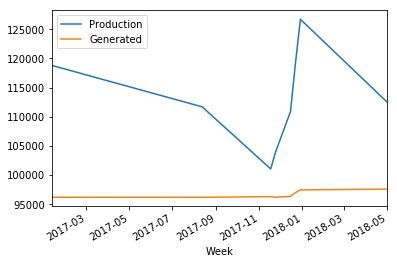

In [25]:
# Plotting the two column for comparison
test_set.plot()